In [ ]:
import pandas as pd
moonshot = pd.read_pickle('moonshot_submissions.p')
moonshot['pIC50'] = moonshot.IC50.apply(lambda i: -np.log10(i))

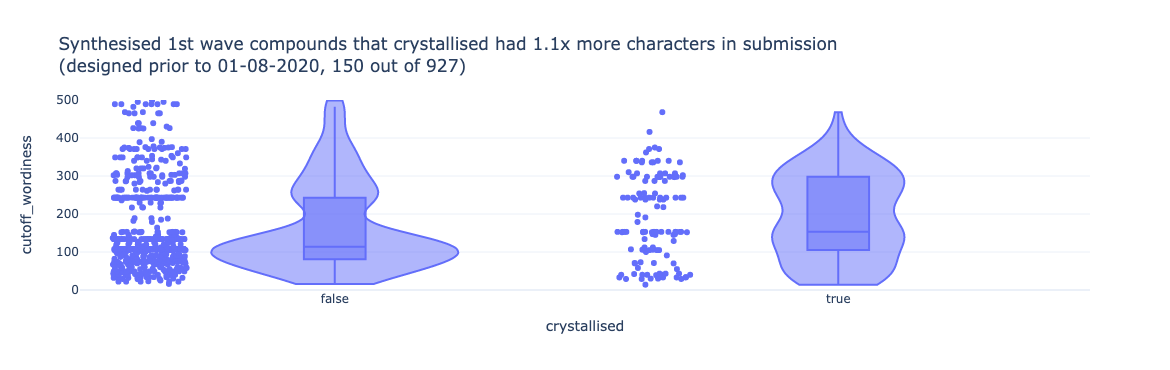

In [410]:
import plotly.express as px

date_cutoff = datetime(2020, 8, 1)
subbed = moonshot.loc[moonshot.MADE & (moonshot['shipment_date'] < date_cutoff)]
#subbed = moonshot.loc[moonshot.MADE]
md_no = subbed.cutoff_wordiness.median() # .loc[~subbed.crystallised]
md_yes = subbed.loc[subbed.in_fragalysis].cutoff_wordiness.median()
fig = px.violin(subbed,
                y='cutoff_wordiness',
          x='crystallised',
            #log_y=True,
          template="plotly_white",
          title=f'Synthesised 1st wave compounds that crystallised had {md_yes/md_no:.1f}x more characters in submission<br>'
                f'(designed prior to {date_cutoff.strftime("%d-%m-%Y")}, {len(subbed.loc[subbed.crystallised])} out of {len(subbed)})',
          box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig.update_yaxes(range=[0, 500])
fig.show()

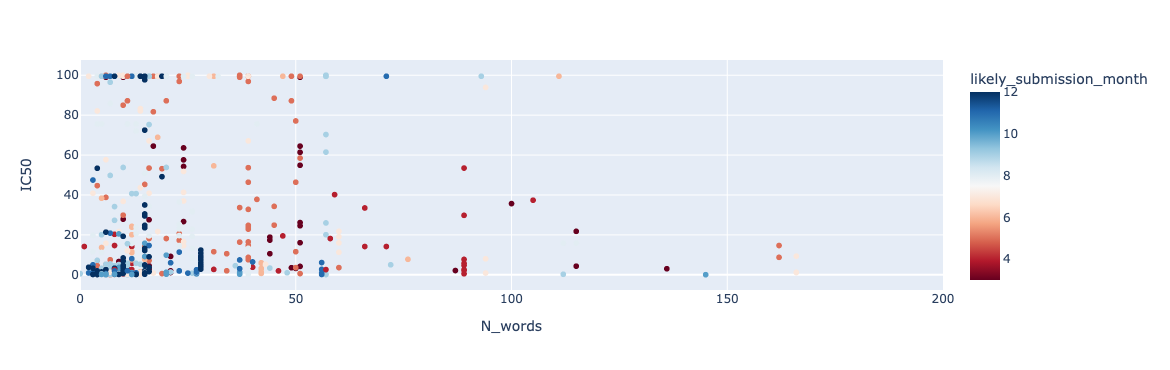

In [411]:
import plotly.express as px
import numpy as np
from datetime import datetime

fig = px.scatter(moonshot.loc[moonshot.likely_submission_month < 13],
          x='N_words', y='IC50',
           #log_y=True,
          color='likely_submission_month',
          #opacity=0.2
                )
fig.update_xaxes(range=[0, 200])
fig.update_coloraxes(colorscale=px.colors.sequential.RdBu)
fig

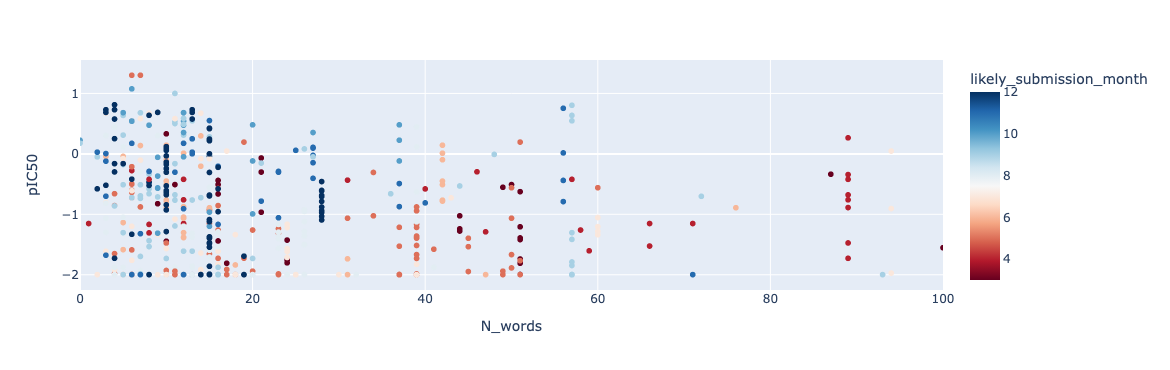

In [412]:
fig = px.scatter(moonshot.loc[moonshot.likely_submission_month < 13],
          x='N_words', y='pIC50',
          color='likely_submission_month',
          #opacity=0.2
                )
fig.update_xaxes(range=[0, 100])
fig.update_coloraxes(colorscale=px.colors.sequential.RdBu)
fig

NameError: name 'pearsonr' is not defined

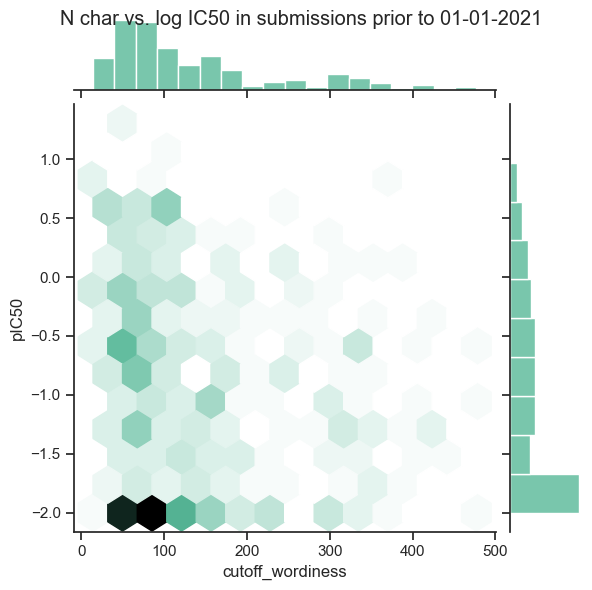

In [413]:
date_cutoff = datetime(2021, 1, 1)

import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")
subbed = moonshot.loc[(moonshot['likely_submission_date'] < date_cutoff) &
                    (moonshot.pIC50 < 2) & # (moonshot.pIC50 < 1.9) &
                     (~moonshot.cutoff_wordiness.isna())& 
                      (moonshot['clean_creator'] != '')]

plot = sns.jointplot(x=subbed.cutoff_wordiness, 
                  y=subbed.pIC50,
                  kind="hex", color="#4CB391")
plot.fig.suptitle(f"N char vs. log IC50 in submissions prior to {date_cutoff.strftime('%d-%m-%Y')}")
pearsonr(subbed.cutoff_wordiness, subbed.pIC50)

In [ ]:
with pd.option_context("max_colwidth", 100):
    display(moonshot.sample(20)['words'])

In [ ]:
import re
moonshot['words'] = moonshot['words'].fillna('')
moonshot['double_words'] = moonshot.words + '. '+moonshot.words
moonshot['penta_words'] = moonshot.double_words + '. '+moonshot.double_words+ '. '+moonshot.words
moonshot['N_chars'] = moonshot.words.apply(len)
moonshot['N_words'] = moonshot.words.apply(lambda x: len(re.findall(r'[\w-]+',x)))

import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")
subbed = moonshot.loc[(moonshot['likely_submission_date'] < datetime(2021, 1, 1)) &
                     (~moonshot.pIC50.isna()) &
                     (~moonshot.cutoff_wordiness.isna())]

plot = sns.jointplot(x=subbed.N_words, 
                  y=subbed.pIC50,
                  kind="hex", color="#4CB391")
plot.fig.suptitle("N_words vs. log IC50 in submissions prior to 1/1/2021")
pearsonr(subbed.N_words, subbed.pIC50)

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
r = Readability(moonshot.loc[20, 'penta_words'])
r.flesch_kincaid().score, r.dale_chall().score

In [ ]:
from readability import Readability
from readability.exceptions import ReadabilityException

def flesch_score(text: str) -> float:
    try:
        return Readability(text).flesch_kincaid().score
    except ReadabilityException as error:
        return np.nan
    
moonshot['flesch'] = moonshot.words.apply(flesch_score)
moonshot['double_flesch'] = moonshot.double_words.apply(flesch_score)
moonshot['penta_flesch'] = moonshot.penta_words.apply(flesch_score)

In [ ]:
import numpy as np
import seaborn as sns
date_cutoff = datetime(2021, 1, 1)
sns.set_theme(style="ticks")
subbed = moonshot.loc[(moonshot['likely_submission_date'] < date_cutoff) &
                     (~moonshot.pIC50.isna())&
                     (~moonshot.double_flesch.isna())]

#subbed = moonshot

plot = sns.jointplot(x=subbed.double_flesch, 
                  y=subbed.pIC50,
                  kind="hex", color="#4CB391")
plot.fig.suptitle(f"Flesch index (50 word min.) vs. log IC50 in submissions (prior to {date_cutoff.strftime('%d-%m-%Y')})")
pearsonr(subbed.double_flesch, subbed.pIC50)

In [ ]:
def dale_score(text: str) -> float:
    try:
        return Readability(text).dale_chall().score
    except ReadabilityException as error:
        return np.nan

moonshot['dale_chall'] = moonshot.words.apply(dale_score)
moonshot['double_dale_chall'] = moonshot.double_words.apply(dale_score)
moonshot['penta_dale_chall'] = moonshot.penta_words.apply(dale_score)


In [ ]:
date_cutoff = datetime(2021, 1, 1)


subbed = moonshot.loc[(moonshot['likely_submission_date'] < date_cutoff) &
                      (~moonshot.double_dale_chall.isna()) &
                     (~moonshot.pIC50.isna())]

plot = sns.jointplot(x=subbed.double_dale_chall, 
                  y=subbed.pIC50,
                  kind="hex", color="#4CB391")

plot.fig.suptitle(f"Dale-Chall index (50 word min.) vs. log IC50 in submissions prior to {date_cutoff.strftime('%d-%m-%Y')}")
pearsonr(subbed.double_dale_chall, subbed.pIC50)

In [ ]:
group_size = moonshot.CID_group.value_counts().to_dict()
moonshot['submission_siblings'] = moonshot.CID_group.map(group_size)

In [ ]:
date_cutoff = datetime(2021, 1, 1)

from scipy.stats import pearsonr


subbed = moonshot.loc[(moonshot['likely_submission_date'] < date_cutoff) &
                      (~moonshot.pIC50.isna()) &
                     (~moonshot.shipment_date.isna())].sort_values('pIC50').drop_duplicates('CID_group')

plot = sns.jointplot(x=subbed.submission_siblings, 
                  y=subbed.pIC50,
                  kind="hex", color="#4CB391")
plot.fig.suptitle(f"submission_siblings vs. log IC50 in submissions prior to {date_cutoff.strftime('%d-%m-%Y')}")
pearsonr(subbed.submission_siblings, subbed.pIC50)

In [ ]:
cutoff = 3
subbed['N_entries'] = subbed.submission_siblings <= cutoff

px.histogram(subbed,
             x='pIC50',
             color='N_entries',
            title=f'Distribution of lowest pIC50 in submission sets'
            )

In [ ]:
# pivot w/ median aggfun shows a signal...
cutoff = 3

px.histogram(
    pd.concat(
        [
        pd.DataFrame(dict(pIC50=pd.pivot_table(moonshot.loc[moonshot.submission_siblings > cutoff],
                                    values='pIC50', index='CID_group', aggfunc=np.median)\
                                   .pIC50,
                         grouping=f'Greater-than-{cutoff}'
                         )
         ),
        pd.DataFrame(dict(pIC50=pd.pivot_table(moonshot.loc[moonshot.submission_siblings <= cutoff],
                                    values='pIC50', index='CID_group', aggfunc=np.median)\
                                   .pIC50,
                         grouping=f'Less-or-equal-to-{cutoff}'
                         )
                 ),
        ]
    ),
    x='pIC50', color='grouping', title='Median pIC50'

)

In [ ]:
fig = px.violin(moonshot.loc[moonshot.likely_submission_month < 13],
          y='pIC50',
          x='classified_method',
          points='all',
                box=True,
            )
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
with pd.option_context("max_colwidth", 100):
    display(moonshot.loc[moonshot['classified_method'] == 'FEP'].sample(20)['words'])

In [ ]:
re.sub(r'^W(\w). ', r'\1 ', 'L. Foo')

In [ ]:
moonshot.loc[(moonshot.words.apply(len) < 2) & (moonshot.clean_creator.apply(len) > 2)]

In [ ]:
px.histogram(moonshot.inferred_submission_date)

In [ ]:
date_cutoff = datetime(2020, 8, 1)
moonshot.loc[moonshot['likely_submission_date'] < date_cutoff].pIC50.describe()

In [ ]:
moonshot.clean_creator.value_counts()

In [ ]:
px.histogram(moonshot.clean_creator.value_counts(), title='Distribution of submission per user')

In [ ]:
moonshot.set_index('clean_creator').pIC50 < np.log10(threshold)

In [ ]:
creators = pd.concat(
            [
                pd.pivot_table(moonshot, values=['likely_submission_month', 'pIC50', 'N_words'], index='clean_creator', aggfunc=np.median),
                moonshot.clean_creator.value_counts().rename('N_submissions'),
                pd.pivot_table(moonshot, values=['ORDERED', 'MADE', 'ASSAYED', 'CRYSTALLISED'], index='clean_creator', aggfunc=sum)
            ], axis='columns').sort_values('MADE', ascending=False)\
    [['likely_submission_month','N_submissions',
      'ORDERED','MADE','ASSAYED','CRYSTALLISED',
      'pIC50','N_words']]\
      .rename(columns={'N_words': 'Mdn N words', 
                       'likely_submission_month': 'Mdn submission month',
                       'N_submissions': 'N submissions',
                       'ORDERED': 'N ordered',
                       'MADE': 'N made',
                       'CRYSTALLISED': 'N crystallised',
                       'ASSAYED': 'N assayed'})

def calc_percent(sucess_series, tally_series) -> str:
    p = sucess_series / tally_series
    se = (((1 - p) * (p)) / (tally_series))**0.5
    return p.apply(lambda v: f'{v*100:.0f}') + '±' + se.apply(lambda v: f'{v:.0%}')

#creators['crystal-over-made %'] = (creators['N crystallised'] * 100 // creators['N made']).fillna(0).astype(int)
creators['crystal-over-made %'] = calc_percent(creators['N crystallised'], creators['N made'])

for threshold in (50, 20, 1, 0.1):
    lower = moonshot.set_index('clean_creator').pIC50 < np.log10(threshold)
    creators[f'N IC50 ≤ {threshold} mM'] = lower[lower].index.to_series().value_counts().fillna(0).astype(int)
    creators[f'N IC50 ≤ {threshold} mM'] = creators[f'N IC50 ≤ {threshold} mM'].fillna(0).astype(int)

with pd.option_context("display.max_rows", None):
    display(
        creators.loc[creators['N made'] > 0]
    )

In [ ]:
fig = px.violin(moonshot, x='CRYSTALLISED', y='pIC50', box=True, points='all', title='pIC50 vs. cystal')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
date_cutoff = datetime(2021, 1, 1)
subbed = moonshot.loc[(moonshot['likely_submission_date'] < date_cutoff)]

fig = px.violin(subbed, x='CRYSTALLISED', y='pIC50', box=True, points='all', 
                title=f'pIC50 vs. cystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
from datetime import datetime

date_cutoff = datetime(2021, 1, 1)
subbed = moonshot.loc[moonshot['likely_submission_date'] < date_cutoff]

fig = px.violin(subbed, x='CRYSTALLISED', y='pIC50', box=True, points='all', 
                title=f'pIC50 vs. cystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
px.line(moonshot, y='submission_date')

In [ ]:
px.line(moonshot, y='likely_submission_date')

In [ ]:
import pandas as pd
moonshot.to_pickle('moonshot_submissions-extra.p')

In [ ]:
import pandas as pd
moonshot = pd.read_pickle('moonshot_submissions-extra.p')

In [ ]:
from sklearn.isotonic import IsotonicRegression
from datetime import date

iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(*list(zip(*[(i,v.toordinal()) for i,v in enumerate(moonshot.submission_date) if str(v) != 'NaT'])))
moonshot['inferred_submission_date'] = pd.Series(iso.predict(np.arange(len(moonshot.submission_date)))).astype(int).apply(datetime.fromordinal)

print('Fraction under', sum(moonshot.submission_date + timedelta(days=30) < (moonshot.inferred_submission_date))/sum(~moonshot.submission_date.isna()))
print('Fraction over', sum(moonshot.submission_date >= moonshot.inferred_submission_date + timedelta(days=1))/sum(~moonshot.submission_date.isna()))

In [ ]:
sum(~moonshot.submission_date.isna()), len(moonshot)

In [ ]:
import plotly.express as px
fig = px.line(moonshot, y=['submission_date', 'inferred_submission_date'], title='The 7% anomaly in the assumption of sequentiality of submissions')
fig.data[0].line.color = "#30D5C8"
fig.data[1].line.color = "#FF7F50"
fig

In [ ]:
from datetime import datetime

date_cutoff = datetime(2020, 8, 1)
subbed = moonshot.loc[(moonshot['submission_date'] < date_cutoff) & moonshot.ASSAYED]

fig = px.violin(subbed, x='CRYSTALLISED', y='pIC50', box=True, points='all', 
                title=f'pIC50 vs. crystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
fifty = np.log10(50)

print('TP', sum((subbed.pIC50 <= fifty) & (subbed.CRYSTALLISED)))
print('FN', sum((subbed.pIC50 <= fifty) & (~subbed.CRYSTALLISED)))
print('TN', sum((subbed.pIC50 > fifty) & (~subbed.CRYSTALLISED)))
print('FP', sum((subbed.pIC50 > fifty) & (subbed.CRYSTALLISED)))
fig

In [ ]:
10**1.392

In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report

fifty = np.log10(50)
with pd.option_context("display.precision", 2):
    display(pd.DataFrame(classification_report(subbed.pIC50 <= fifty, subbed.CRYSTALLISED, output_dict=True)))
    
pd.DataFrame(confusion_matrix(subbed.pIC50 <= fifty, subbed.CRYSTALLISED), columns=['no xstal', 'xstal'], index=['high IC50', 'low IC50'])

In [ ]:
subbed[['CRYSTALLISED', 'IC50+']]

In [ ]:
from datetime import datetime

date_cutoff = datetime(2050, 1, 1)
subbed = moonshot.loc[moonshot['inferred_submission_date'] < date_cutoff]

fig = px.violin(subbed, x='CRYSTALLISED', y='pIC50', box=True, points='all', 
                title=f'pIC50 vs. cystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
pd.pivot_table(subbed, index='CRYSTALLISED', values='pIC50', aggfunc=np.median)

In [424]:
dated = pd.read_csv('moonshot_dated_data.csv', index_col=0)

import re

def fix_ic50(value):
    if str(value) == 'nan':
        return 100
    if isinstance(value, float):
        return value
    rex = re.search('([\d.]+)', str(value))
    if rex:
        return float(rex.group(1))
    return 100

In [425]:
ic50 = dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Avg IC50 (uM)'].apply(fix_ic50)
assay_date = pd.to_datetime(dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Run Date'], format='%Y%m%d')
digit = dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Avg IC50 (uM)'].str.replace('.', '', regex=False).str.strip().str.isdigit()

def quarterify(date):
    start = datetime(year=2020, month=1, day=1)
    for i in range(100):
        if date < start + timedelta(days=365 // 3) * i:
            return i
        
quarter = assay_date.apply(quarterify)

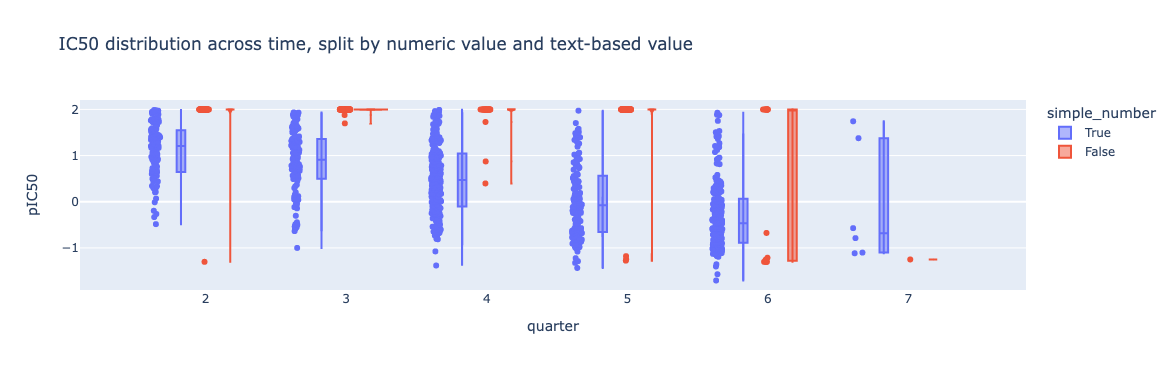

In [426]:
fig = px.violin(pd.DataFrame(dict(pIC50=ic50.apply(np.log10), quarter=quarter, simple_number=digit)), 
                x='quarter', y='pIC50', color='simple_number',
                box=True, points='all',
               title='IC50 distribution across time, split by numeric value and text-based value'
               )
fig.update_traces(spanmode = 'hard')
fig

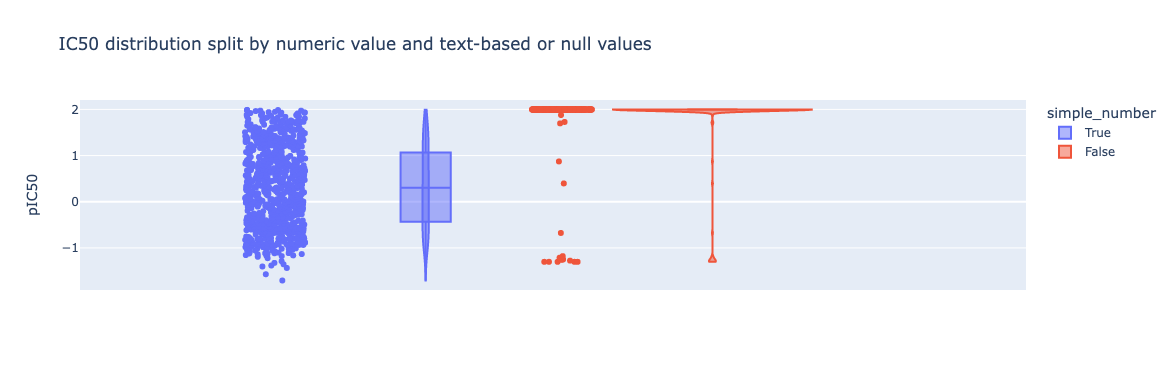

In [427]:
fig = px.violin(pd.DataFrame(dict(pIC50=ic50.apply(np.log10), quarter=quarter, simple_number=digit)), 
                y='pIC50', color='simple_number',
                box=True, points='all',
               title='IC50 distribution split by numeric value and text-based or null values'
               )
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
dated = pd.read_csv('moonshot_dated_data.csv', index_col=0)

import re

def fix_ic50(value):
    if isinstance(value, float):  # including nan
        return value
    rex = re.search('^([\d.]+)$', str(value))
    return float(rex.group(1)) if rex else np.nan

ic50 = dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Avg IC50 (uM)'].apply(fix_ic50)

moonshot['strict_IC50'] = moonshot['CID (canonical)'].map(ic50)
moonshot['strict_pIC50'] = moonshot['strict_IC50'].apply(np.log10)

In [ ]:
dated['ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Avg IC50 (uM)'].value_counts(ascending=False).head(20)

In [ ]:
sum(ic50.isna()), len(ic50)

In [ ]:
fig = px.violin(moonshot, x='CRYSTALLISED', y='strict_pIC50', box=True, points='all', title='pIC50 vs. cystal (simple digits only IC50)')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
date_cutoff = datetime(2020, 9, 1)
subbed = moonshot.loc[moonshot.MADE & (moonshot['submission_date'] < date_cutoff) & (moonshot['clean_creator'] != '')]
fig = px.violin(subbed, x='CRYSTALLISED', y='strict_pIC50', box=True, points='all', title=f'pIC50 vs. cystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
fig

In [ ]:
px.histogram(moonshot, 'shipment_date', color='CRYSTALLISED', nbins=12*2, title='Distribution of entries across shipment date')

In [ ]:
px.scatter(moonshot, 'shipment_date', 'submission_date', color='CRYSTALLISED', opacity=0.2, 
           title='Relationship between submission and shipment dates')

In [ ]:
sum(moonshot['CID (canonical)'].isin(in_fragalysis)), sum(moonshot.CRYSTALLISED)

In [ ]:
import io
import requests

response = requests.get('https://fragalysis.diamond.ac.uk/api/targets/?title=Mpro')
meta_url = response.json()['results'][0]['metadata']
response = meta_url = response.json()['results'][0]['metadata']
response = requests.get(meta_url)
metadata = pd.read_csv(io.StringIO(response.text), index_col=0)
in_fragalysis = metadata.alternate_name.to_list()

moonshot['in_fragalysis'] = moonshot['CID (canonical)'].isin(in_fragalysis)

In [ ]:
px.scatter(moonshot, 'shipment_date', 'submission_date', color='in_fragalysis', opacity=0.2, 
           title='Relationship between submission and shipment dates')

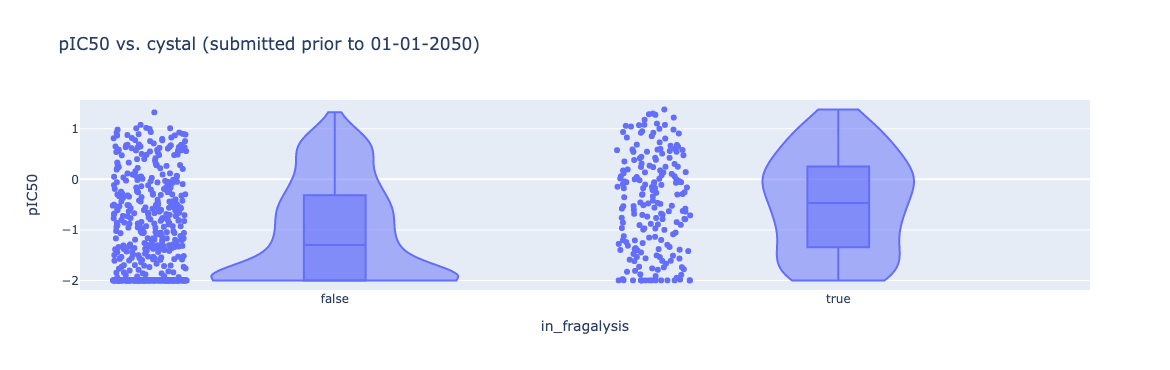

,False,True,accuracy,macro avg,weighted avg
precision,0.38,0.85,0.52,0.62,0.70
recall,0.87,0.36,0.52,0.61,0.52
f1-score,0.53,0.50,0.52,0.52,0.51
support,218.00,472.00,0.52,690.00,690.00


,no xstal,xstal
high IC50,189,29
low IC50,304,168


In [430]:
date_cutoff = datetime(2050, 1, 1)
subbed = moonshot.loc[moonshot.MADE & (moonshot['submission_date'] < date_cutoff) & (moonshot['clean_creator'] != '')].drop_duplicates('CID (canonical)')
fig = px.violin(subbed, x='in_fragalysis', y='pIC50', 
                hover_data=['CID (canonical)', 'clean_creator', 'shipment_date'],
                box=True, points='all', title=f'pIC50 vs. cystal (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
display(fig)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report


with pd.option_context("display.precision", 2):
    display(pd.DataFrame(classification_report(subbed.IC50 <= 50, subbed.in_fragalysis, output_dict=True)))
    
pd.DataFrame(confusion_matrix(subbed.IC50 <= 50, subbed.in_fragalysis), columns=['no xstal', 'xstal'], index=['high IC50', 'low IC50'])

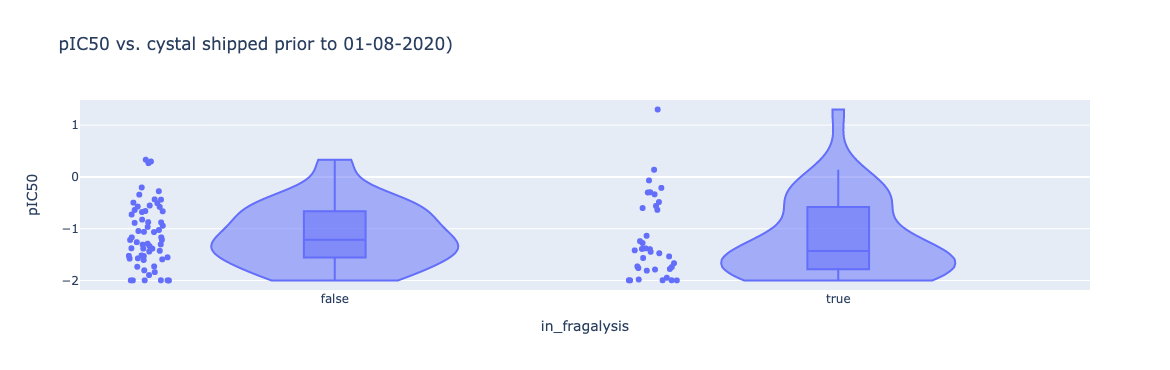

,False,True,accuracy,macro avg,weighted avg
precision,0.92,0.17,0.79,0.54,0.85
recall,0.84,0.32,0.79,0.58,0.79
f1-score,0.88,0.22,0.79,0.55,0.82
support,716.00,73.00,0.79,789.00,789.00


,no xstal,xstal
high IC50,600,116
low IC50,50,23


In [431]:
date_cutoff = datetime(2020, 8, 1)
subbed = moonshot.loc[moonshot.MADE & (moonshot['shipment_date'] < date_cutoff) & (moonshot['clean_creator'] != '')].drop_duplicates('CID (canonical)')
fig = px.violin(subbed, x='in_fragalysis', y='pIC50', 
                hover_data=['CID (canonical)', 'clean_creator', 'shipment_date'],
                box=True, points='all', title=f'pIC50 vs. cystal shipped prior to {date_cutoff.strftime("%d-%m-%Y")})')
fig.update_traces(spanmode = 'hard')
display(fig)
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report


with pd.option_context("display.precision", 2):
    display(pd.DataFrame(classification_report(subbed.IC50 <= 50, subbed.in_fragalysis, output_dict=True)))
    
pd.DataFrame(confusion_matrix(subbed.IC50 <= 50, subbed.in_fragalysis), columns=['no xstal', 'xstal'], index=['high IC50', 'low IC50'])

In [398]:
moonshot.to_pickle('moonshot_submissions.p')

In [428]:
10**(-1.25)

0.05623413251903491